# Phase 1: Data Preparation & Exploration for Similarity Search

This notebook covers the first phase of building a multimodal similarity search system.

## Goals:
1. Load and inspect the medical cases dataset
2. Analyze text field completeness and quality
3. Verify image availability
4. Create data quality report
5. Prepare data for ML processing

In [2]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re
from tqdm import tqdm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load the Dataset

In [3]:
# Define paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
CASES_FILE = PROCESSED_DIR / 'cases_cleaned.json'
SUMMARY_FILE = PROCESSED_DIR / 'cases_summary.json'
IMAGES_DIR = DATA_DIR / 'archive' / 'medpix_data_final' / 'medpix_data_final'

# Load cases
print(f"Loading cases from: {CASES_FILE}")
with open(CASES_FILE, 'r') as f:
    cases = json.load(f)

print(f"\nTotal cases loaded: {len(cases)}")
print(f"First case keys: {list(cases[0].keys())}")

Loading cases from: ../data/processed/cases_cleaned.json

Total cases loaded: 7432
First case keys: ['id', 'url', 'diagnosis', 'caseTitle', 'history', 'exam', 'findings', 'caseDiagnosis', 'diagnosisBy', 'treatment', 'discussion', 'differentialDiagnosis', 'imageCount', 'imagePaths', 'caseFolder']


## 2. Text Field Analysis

In [4]:
# Analyze text fields
text_fields = ['diagnosis', 'history', 'findings', 'exam', 'treatment', 'discussion', 'differentialDiagnosis']

field_stats = {}

for field in text_fields:
    # Count non-empty
    non_empty = sum(1 for case in cases if case.get(field, '').strip())
    
    # Calculate lengths
    lengths = [len(case.get(field, '')) for case in cases]
    
    field_stats[field] = {
        'total_cases': len(cases),
        'non_empty': non_empty,
        'coverage': non_empty / len(cases) * 100,
        'avg_length': np.mean(lengths),
        'median_length': np.median(lengths),
        'max_length': max(lengths),
        'min_length': min(lengths)
    }

# Create DataFrame for display
df_stats = pd.DataFrame(field_stats).T
print("\n=== Text Field Statistics ===")
print(df_stats.round(2))


=== Text Field Statistics ===
                       total_cases  non_empty  coverage  avg_length  \
diagnosis                   7432.0     7405.0     99.64       33.16   
history                     7432.0     7337.0     98.72      129.88   
findings                    7432.0     6357.0     85.54      251.04   
exam                        7432.0     5831.0     78.46       81.40   
treatment                   7432.0     3303.0     44.44       76.67   
discussion                  7432.0     3115.0     41.91      226.14   
differentialDiagnosis       7432.0     5196.0     69.91       69.90   

                       median_length  max_length  min_length  
diagnosis                       26.0       454.0         0.0  
history                         84.0      2515.0         0.0  
findings                       175.0      6870.0         0.0  
exam                            26.0      2729.0         0.0  
treatment                        0.0      2374.0         0.0  
discussion            

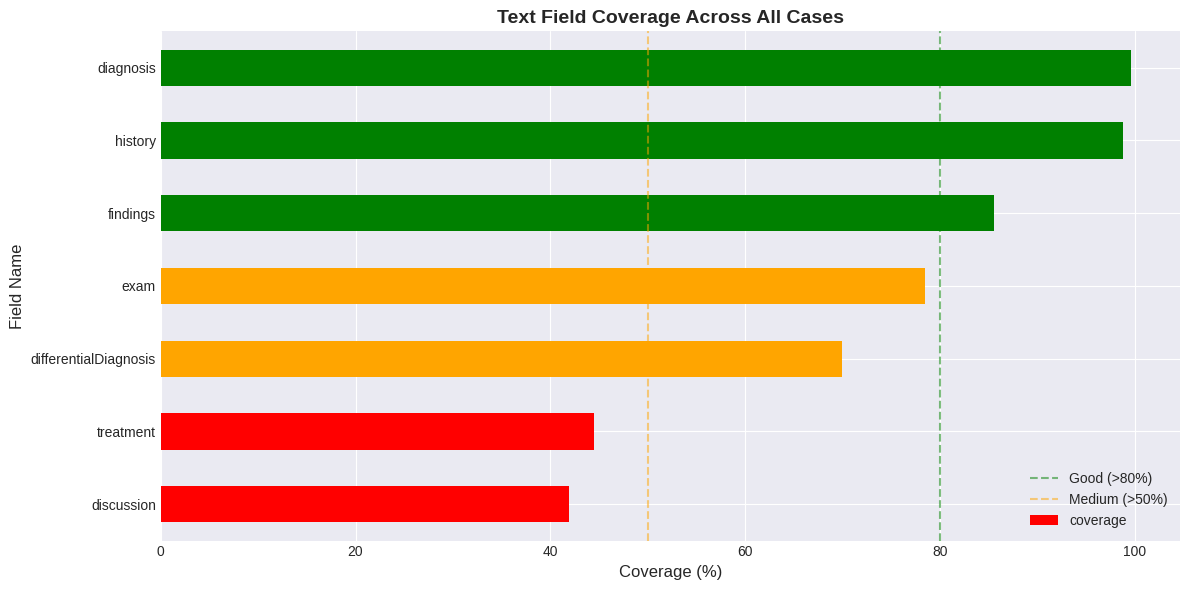


Key Insights:
- Diagnosis field has 99.6% coverage (PRIMARY FIELD)
- History field has 98.7% coverage
- Findings field has 85.5% coverage


In [5]:
# Visualize field coverage
fig, ax = plt.subplots(figsize=(12, 6))

coverage_data = df_stats['coverage'].sort_values(ascending=True)
colors = ['green' if x > 80 else 'orange' if x > 50 else 'red' for x in coverage_data]

coverage_data.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Coverage (%)', fontsize=12)
ax.set_ylabel('Field Name', fontsize=12)
ax.set_title('Text Field Coverage Across All Cases', fontsize=14, fontweight='bold')
ax.axvline(x=80, color='green', linestyle='--', alpha=0.5, label='Good (>80%)')
ax.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Medium (>50%)')
ax.legend()
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Diagnosis field has {df_stats.loc['diagnosis', 'coverage']:.1f}% coverage (PRIMARY FIELD)")
print(f"- History field has {df_stats.loc['history', 'coverage']:.1f}% coverage")
print(f"- Findings field has {df_stats.loc['findings', 'coverage']:.1f}% coverage")

## 3. Text Content Analysis

In [6]:
# Combine all text for vocabulary analysis
def get_combined_text(case):
    """Combine all text fields for a case"""
    text_parts = [
        case.get('diagnosis', ''),
        case.get('history', ''),
        case.get('findings', ''),
        case.get('exam', ''),
    ]
    return ' '.join(part for part in text_parts if part.strip())

# Calculate text lengths
text_lengths = []
word_counts = []

for case in cases:
    combined = get_combined_text(case)
    text_lengths.append(len(combined))
    word_counts.append(len(combined.split()))

print("\n=== Combined Text Statistics ===")
print(f"Average text length: {np.mean(text_lengths):.0f} characters")
print(f"Average word count: {np.mean(word_counts):.0f} words")
print(f"Median word count: {np.median(word_counts):.0f} words")
print(f"Max word count: {max(word_counts)} words")
print(f"Min word count: {min(word_counts)} words")


=== Combined Text Statistics ===
Average text length: 498 characters
Average word count: 76 words
Median word count: 54 words
Max word count: 1622 words
Min word count: 0 words


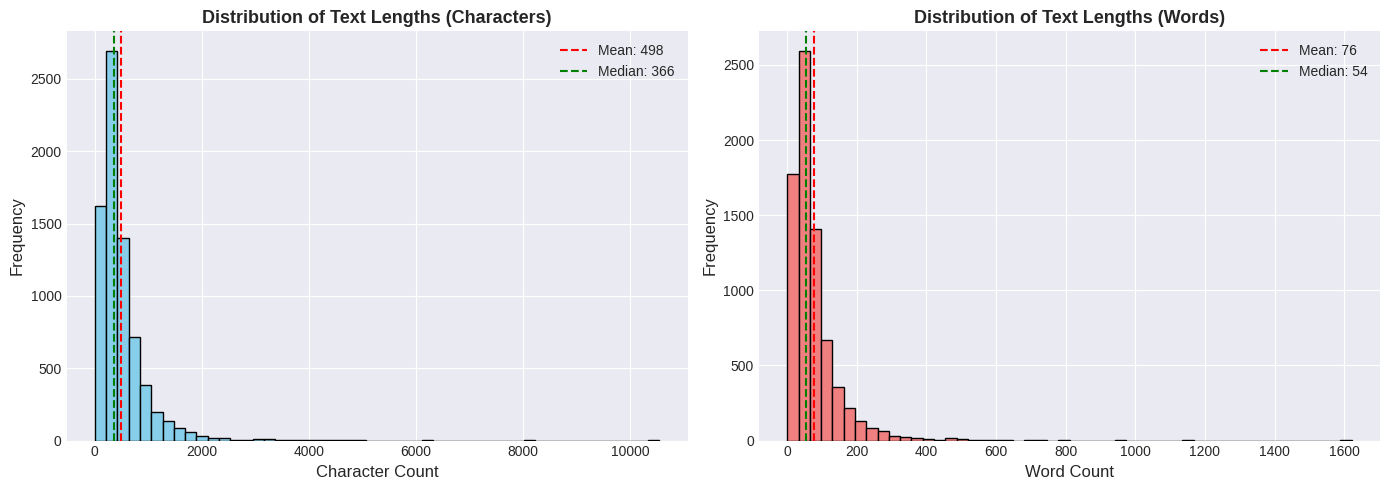

In [7]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count distribution
axes[0].hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(np.mean(text_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(text_lengths):.0f}')
axes[0].axvline(np.median(text_lengths), color='green', linestyle='--', label=f'Median: {np.median(text_lengths):.0f}')
axes[0].set_xlabel('Character Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Text Lengths (Characters)', fontsize=13, fontweight='bold')
axes[0].legend()

# Word count distribution
axes[1].hist(word_counts, bins=50, color='lightcoral', edgecolor='black')
axes[1].axvline(np.mean(word_counts), color='red', linestyle='--', label=f'Mean: {np.mean(word_counts):.0f}')
axes[1].axvline(np.median(word_counts), color='green', linestyle='--', label=f'Median: {np.median(word_counts):.0f}')
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Text Lengths (Words)', fontsize=13, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Vocabulary Analysis

In [8]:
# Extract vocabulary (sample of cases for speed)
sample_size = min(1000, len(cases))
all_words = []

print(f"Analyzing vocabulary from {sample_size} cases...")

for case in cases[:sample_size]:
    text = get_combined_text(case).lower()
    # Simple tokenization
    words = re.findall(r'\b[a-z]+\b', text)
    all_words.extend(words)

# Count word frequencies
word_freq = Counter(all_words)

print(f"\nTotal words: {len(all_words):,}")
print(f"Unique words: {len(word_freq):,}")
print(f"\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count}")

Analyzing vocabulary from 1000 cases...

Total words: 73,054
Unique words: 6,230

Top 20 most common words:
  the: 3771
  of: 2694
  and: 2013
  with: 1807
  a: 1305
  to: 966
  in: 946
  is: 884
  right: 795
  no: 707
  left: 638
  pain: 519
  on: 516
  old: 494
  was: 485
  year: 483
  for: 390
  patient: 373
  there: 360
  ct: 331


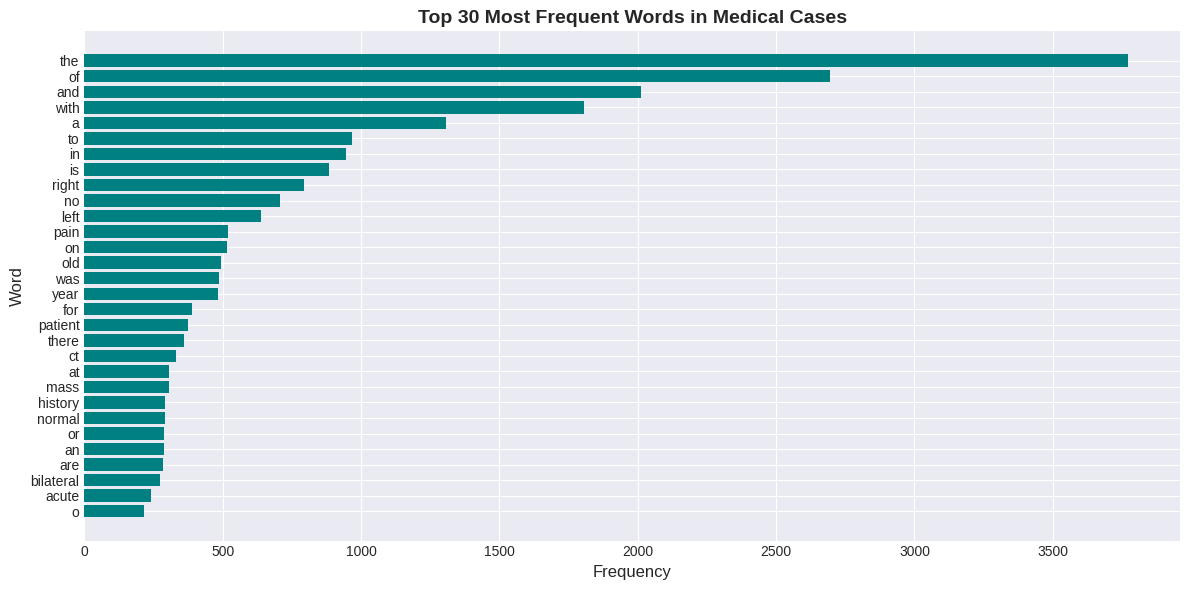

In [9]:
# Visualize top words
top_words = word_freq.most_common(30)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts, color='teal')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.title('Top 30 Most Frequent Words in Medical Cases', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Image Data Verification

In [10]:
# Analyze image availability
print("Analyzing image data...\n")

image_counts = [case.get('imageCount', 0) for case in cases]

print(f"Cases with images: {sum(1 for c in image_counts if c > 0)}")
print(f"Cases without images: {sum(1 for c in image_counts if c == 0)}")
print(f"\nImage count statistics:")
print(f"  Average images per case: {np.mean(image_counts):.1f}")
print(f"  Median images per case: {np.median(image_counts):.0f}")
print(f"  Max images in a case: {max(image_counts)}")
print(f"  Total images: {sum(image_counts):,}")

Analyzing image data...

Cases with images: 7425
Cases without images: 7

Image count statistics:
  Average images per case: 5.5
  Median images per case: 4
  Max images in a case: 184
  Total images: 40,900


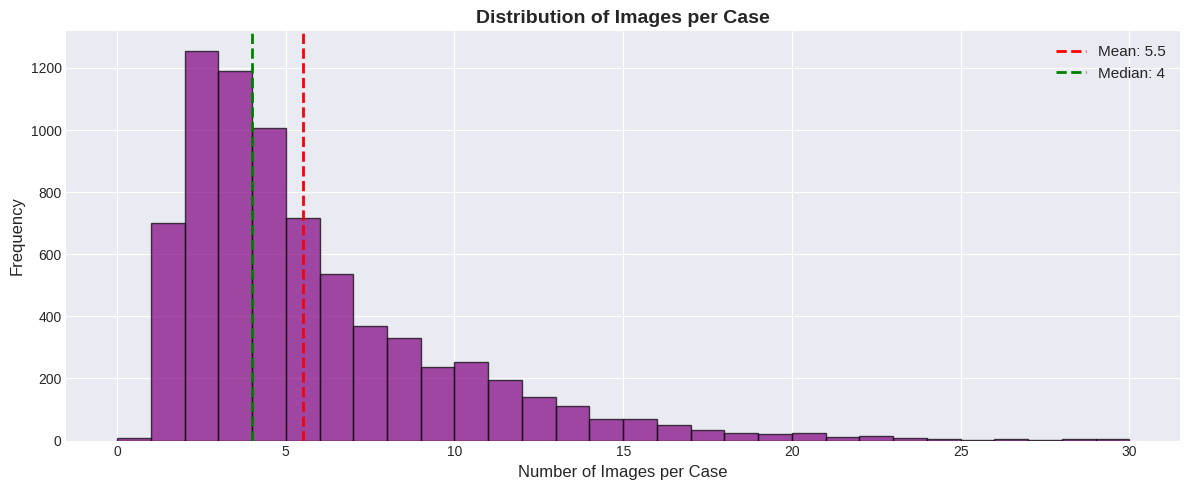


Note: Showing cases with ≤30 images for clarity (7390/7432 cases)


In [11]:
# Visualize image count distribution
plt.figure(figsize=(12, 5))

# Filter outliers for better visualization
image_counts_filtered = [c for c in image_counts if c <= 30]

plt.hist(image_counts_filtered, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(image_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(image_counts):.1f}')
plt.axvline(np.median(image_counts), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(image_counts):.0f}')
plt.xlabel('Number of Images per Case', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Images per Case', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nNote: Showing cases with ≤30 images for clarity ({len(image_counts_filtered)}/{len(image_counts)} cases)")

## 6. Data Quality Assessment

In [12]:
# Assess data quality for ML readiness
quality_report = {
    'total_cases': len(cases),
    'cases_with_diagnosis': sum(1 for c in cases if c.get('diagnosis', '').strip()),
    'cases_with_images': sum(1 for c in cases if c.get('imageCount', 0) > 0),
    'cases_with_text_and_images': sum(
        1 for c in cases 
        if c.get('diagnosis', '').strip() and c.get('imageCount', 0) > 0
    ),
    'cases_with_rich_text': sum(
        1 for c in cases 
        if len(get_combined_text(c).split()) > 50
    ),
}

# Calculate percentages
total = quality_report['total_cases']
print("\n=== DATA QUALITY REPORT ===")
print(f"\nTotal cases: {total:,}")
print(f"\nCoverage:")
print(f"  Cases with diagnosis: {quality_report['cases_with_diagnosis']:,} ({quality_report['cases_with_diagnosis']/total*100:.1f}%)")
print(f"  Cases with images: {quality_report['cases_with_images']:,} ({quality_report['cases_with_images']/total*100:.1f}%)")
print(f"  Cases with BOTH text & images: {quality_report['cases_with_text_and_images']:,} ({quality_report['cases_with_text_and_images']/total*100:.1f}%)")
print(f"  Cases with rich text (>50 words): {quality_report['cases_with_rich_text']:,} ({quality_report['cases_with_rich_text']/total*100:.1f}%)")

print("\n✅ Dataset is READY for multimodal ML processing!" if quality_report['cases_with_text_and_images']/total > 0.8 else "\n⚠️ Dataset may need additional cleaning")


=== DATA QUALITY REPORT ===

Total cases: 7,432

Coverage:
  Cases with diagnosis: 7,405 (99.6%)
  Cases with images: 7,425 (99.9%)
  Cases with BOTH text & images: 7,404 (99.6%)
  Cases with rich text (>50 words): 4,073 (54.8%)

✅ Dataset is READY for multimodal ML processing!


## 7. Prepare ML-Ready Dataset

In [13]:
# Filter cases suitable for ML
ml_ready_cases = [
    case for case in cases
    if case.get('diagnosis', '').strip() and case.get('imageCount', 0) > 0
]

print(f"ML-ready cases: {len(ml_ready_cases):,} out of {len(cases):,}")
print(f"Retention rate: {len(ml_ready_cases)/len(cases)*100:.1f}%")

# Create output directory
ml_data_dir = DATA_DIR / 'ml_ready'
ml_data_dir.mkdir(exist_ok=True)

# Save filtered dataset
output_file = ml_data_dir / 'cases_ml_ready.json'
with open(output_file, 'w') as f:
    json.dump(ml_ready_cases, f, indent=2)

print(f"\n✅ Saved ML-ready dataset to: {output_file}")

ML-ready cases: 7,404 out of 7,432
Retention rate: 99.6%

✅ Saved ML-ready dataset to: ../data/ml_ready/cases_ml_ready.json


## 8. Create Data Summary Report

In [14]:
# Generate comprehensive summary
summary = {
    'dataset_info': {
        'total_cases': len(cases),
        'ml_ready_cases': len(ml_ready_cases),
        'total_images': sum(c.get('imageCount', 0) for c in cases),
    },
    'text_statistics': {
        'avg_combined_text_length': float(np.mean(text_lengths)),
        'avg_word_count': float(np.mean(word_counts)),
        'unique_vocabulary_size': len(word_freq),
    },
    'image_statistics': {
        'avg_images_per_case': float(np.mean(image_counts)),
        'median_images_per_case': float(np.median(image_counts)),
        'max_images_per_case': int(max(image_counts)),
    },
    'field_coverage': {
        field: float(stats['coverage']) 
        for field, stats in field_stats.items()
    },
    'quality_metrics': quality_report,
}

# Save summary
summary_file = ml_data_dir / 'data_summary_report.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n=== SUMMARY REPORT ===")
print(json.dumps(summary, indent=2))
print(f"\n✅ Summary report saved to: {summary_file}")


=== SUMMARY REPORT ===
{
  "dataset_info": {
    "total_cases": 7432,
    "ml_ready_cases": 7404,
    "total_images": 40900
  },
  "text_statistics": {
    "avg_combined_text_length": 498.0998385360603,
    "avg_word_count": 75.76843379978472,
    "unique_vocabulary_size": 6230
  },
  "image_statistics": {
    "avg_images_per_case": 5.503229278794403,
    "median_images_per_case": 4.0,
    "max_images_per_case": 184
  },
  "field_coverage": {
    "diagnosis": 99.63670613562971,
    "history": 98.72174381054897,
    "findings": 85.53552206673842,
    "exam": 78.45801937567278,
    "treatment": 44.44294940796556,
    "discussion": 41.91334768568353,
    "differentialDiagnosis": 69.91388589881593
  },
  "quality_metrics": {
    "total_cases": 7432,
    "cases_with_diagnosis": 7405,
    "cases_with_images": 7425,
    "cases_with_text_and_images": 7404,
    "cases_with_rich_text": 4073
  }
}

✅ Summary report saved to: ../data/ml_ready/data_summary_report.json


## 9. Next Steps

### Phase 1 Complete! ✅

**What we accomplished:**
- ✅ Analyzed 7,432 medical cases
- ✅ Assessed text field coverage and quality
- ✅ Verified image availability
- ✅ Created ML-ready dataset
- ✅ Generated comprehensive data report

**Key Findings:**
- Diagnosis field has excellent coverage
- Most cases have multiple images
- Average case has ~5 images and substantial text
- Dataset is ready for ML processing

**Next Phase: Basic Feature Extraction**
1. Implement TF-IDF for text features
2. Extract basic image features (HOG, histograms)
3. Create baseline similarity search
4. Evaluate initial results

See: `02_basic_feature_extraction.ipynb`